# Бонусное домашнее задание

## Part 0

В данном домашнем задании вам предстоит реализовать СLIP -- self-supervision модель которая выучивает зависимости между картинками и текстов в едином векторном пространстве. Для выполнения этого домашнего задания вам понадобится GPU и несколько дополнительных библиотек. Автор рекомендует делать все исключительно в Kaggle. 


[Ссылка на датасет](https://www.kaggle.com/datasets/keenwarrior/small-flicker-data-for-image-captioning)

[Ссылка на статью](https://openai.com/research/clip)

Задания в ноутбуке будут во многом опираться на статью, поэтому рекомендуется ее прочитать перед выполнением.

In [1]:
# !pip install timm
# !pip install transformers

In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pandas as pd
import timm

import warnings
warnings.filterwarnings('ignore')

device = torch.device("mps")
PATH_TO_IMAGES = 'data'

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## Part 1 (8 баллов)

Для начала нам нужно реализовать составляющие модели: Кодировщик картинок, текста и проектор на какое-то маломерное пространство. В папке с заданием есть соответствующие файлы, заполните пропуски в них опираясь на docstring-и.

Разбалловка следующая: 

Правильно реализованные кодировщики: 2 балла.

Правильно реализованный проектор: 2 балла.

Правильно реализованный класс СLIP: 4 балла.

In [3]:
from CLIPDataset import CLIPDataset
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from ImageEncoder import ImageEncoder
from ProjectionHead import ProjectionHead
from TextEncoder import TextEncoder

In [ ]:
class CLIP(nn.Module):
    def __init__(self, image_embedding=2048, text_embedding=768, temp =1.0):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projections = ProjectionHead(image_embedding)
        self.text_projections = ProjectionHead(text_embedding)
        self.temp = temp
    def forward(self, batch):
        """
        :batch: dict of images and text
        Here is what you should do:
        1) extract image and text features from batch
        2) project features into projection space (small latent space)
        3) compute cosine similarity with temperature this will be your logits
        4) compute "true" logits (eg. cosine similarity between images and images, text and text)
        5) create targets by averaging similarities from step above (do not forget about temperature)
        6) compute mean loss (see paper)
        7) return loss

        Overall: read paper.
        
        """
        image_features = self.image_encoder(batch['image'])
        text_features = self.text_encoder(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        image_embeddings = self.image_projections(image_features)
        text_embeddings = self.text_projections(text_features)

        logits = (image_embeddings @ text_embeddings.T) / self.temp
        targets = torch.nn.functional.softmax((image_embeddings @ image_embeddings.T + text_embeddings @ text_embeddings.T) / 2 * self.temp, dim=-1)

        return ((CE(logits, targets) + CE(logits.T, targets.T)) / 2).mean()
    

def CE(preds, targets):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    return loss   

# Part 2. (0 Баллов)

Здесь вам нужно вписать правильный путь до csv файла на своей машине и запустить код.

In [5]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{PATH_TO_IMAGES}/captions.csv")
    dataframe["id"] = np.array(list(dataframe.index))
    max_id = dataframe["id"].max() + 1
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

In [6]:
def build_loaders(dataframe, tokenizer, mode):
    dataset = CLIPDataset(
        f"{PATH_TO_IMAGES}",
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer
    )
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        num_workers=1,
        shuffle=True if mode == "train" else False,
    )
    return dataloader, dataset

In [7]:
class AvgMeter:
    def __init__(self, name="CrossEntropyLoss"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text
    
    def __format__(self, formatspec):
        text = f"{self.name}: {format(self.avg, formatspec)}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [8]:
def train(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    for batch in tqdm(train_loader, desc="Training", total=len(train_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()
        loss_meter.update(loss.item(), batch["image"].shape[0])
    return loss_meter

@torch.no_grad()
def validate(model, validation_loader):
    loss_meter = AvgMeter()
    for batch in tqdm(validation_loader, desc="Validating", total=len(validation_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        loss = model(batch)
        loss_meter.update(loss.item(), batch["image"].shape[0])
    return loss_meter

## Part 3. (2 балла)

За вас написан минимальный код для обучения, если он запускается и модель учится, то за этот пункт вы получите 0.5 балла. Чтобы получить полный балл за задание вам нужно будет провести несколько экспериментов и поподбирать гиперпараметры. Можно начать со статьи.

In [9]:
import itertools
EPOCH = 10
def procedure():
    train_df, validation_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    train_loader, _ = build_loaders(train_df, tokenizer, mode="train")
    val_loader, _ = build_loaders(validation_df, tokenizer, mode="valid")
    model = CLIP().to(device)
    params = [{"params": model.image_encoder.parameters()}, 
              {"params" : model.text_encoder.parameters()},
              {"params" : itertools.chain(model.image_projections.parameters(),
                                          model.text_projections.parameters())}]
    optimizer = torch.optim.Adam(params)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=1, factor=0.8)
    step="epoch"
    for epoch in range(EPOCH):
        print(f"Epoch: {epoch}. Train and Validation in progress...")
        model.train()
        train_loss = train(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        val_loss = validate(model, val_loader)
        
        lr_scheduler.step(val_loss.avg)
        print(f"Epoch: {epoch},", end="\n")
        print(f"Train loss: {train_loss:0.3f}", end="\n")
        print(f"Validation loss: {val_loss:0.3f}")
    return model

In [10]:
model = procedure()

Epoch: 0. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 0,
Train loss: CrossEntropyLoss: 5.063
Validation loss: CrossEntropyLoss: 3.231
Epoch: 1. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 1,
Train loss: CrossEntropyLoss: 2.809
Validation loss: CrossEntropyLoss: 2.558
Epoch: 2. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 2,
Train loss: CrossEntropyLoss: 2.182
Validation loss: CrossEntropyLoss: 2.028
Epoch: 3. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 3,
Train loss: CrossEntropyLoss: 1.592
Validation loss: CrossEntropyLoss: 1.698
Epoch: 4. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 4,
Train loss: CrossEntropyLoss: 1.240
Validation loss: CrossEntropyLoss: 1.606
Epoch: 5. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 5,
Train loss: CrossEntropyLoss: 1.007
Validation loss: CrossEntropyLoss: 1.439
Epoch: 6. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 6,
Train loss: CrossEntropyLoss: 0.907
Validation loss: CrossEntropyLoss: 1.445
Epoch: 7. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 7,
Train loss: CrossEntropyLoss: 0.736
Validation loss: CrossEntropyLoss: 1.471
Epoch: 8. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 8,
Train loss: CrossEntropyLoss: 0.593
Validation loss: CrossEntropyLoss: 1.427
Epoch: 9. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 9,
Train loss: CrossEntropyLoss: 0.529
Validation loss: CrossEntropyLoss: 1.363


## Part 4 (0 баллов)

Просто посмотрим на результаты.

In [11]:
@torch.inference_mode()
def get_image_embeddings(valid_df, model):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    valid_loader, _ = build_loaders(valid_df, tokenizer, mode="valid")
    valid_image_embeddings = []
    for batch in tqdm(valid_loader, desc="Getting embeddings", total=len(valid_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        image_features = model.image_encoder(batch["image"]).to(device)
        image_embeddings = model.image_projections(image_features)
        valid_image_embeddings.append(image_embeddings)
    return torch.cat(valid_image_embeddings)

In [12]:
import matplotlib.pyplot as plt
@torch.inference_mode()
def find_match(model, image_embeddings, text, image_filenames, num_examples=4):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    text_encoded = tokenizer([text])
    batch = {key : torch.tensor(value).to(device) for key, value in text_encoded.items()}
    
    text_features = model.text_encoder(batch["input_ids"], batch["attention_mask"])
    text_embeddings = model.text_projections(text_features)
    
    norm_image_embeddings = nn.functional.normalize(image_embeddings, p=2, dim=-1)
    norm_text_embeddings = nn.functional.normalize(text_embeddings, p=2, dim=-1)
    
    similarity = norm_text_embeddings @ norm_image_embeddings.T
    
    ans, ans_index = torch.topk(similarity.squeeze(0), num_examples * 5)
    match = [image_filenames[index] for index in ans_index[::5]]
    fig, ax = plt.subplots(int(num_examples/2), int(num_examples/2), figsize= (10, 10))
    for m, a in zip(match, ax.flatten()):
        image = Image.open(f"{PATH_TO_IMAGES}/images" + f"/{m}")
        image = image.convert("RGB")
        a.imshow(image)
        a.axis("off")
    plt.show()
    

In [13]:
_, valid_df = make_train_valid_dfs()
image_embeddings = get_image_embeddings(valid_df, model)

Getting embeddings:   0%|          | 0/32 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/konstantin/Desktop/HSE/ДЗ/DL/shw-04-ssl-bonus/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


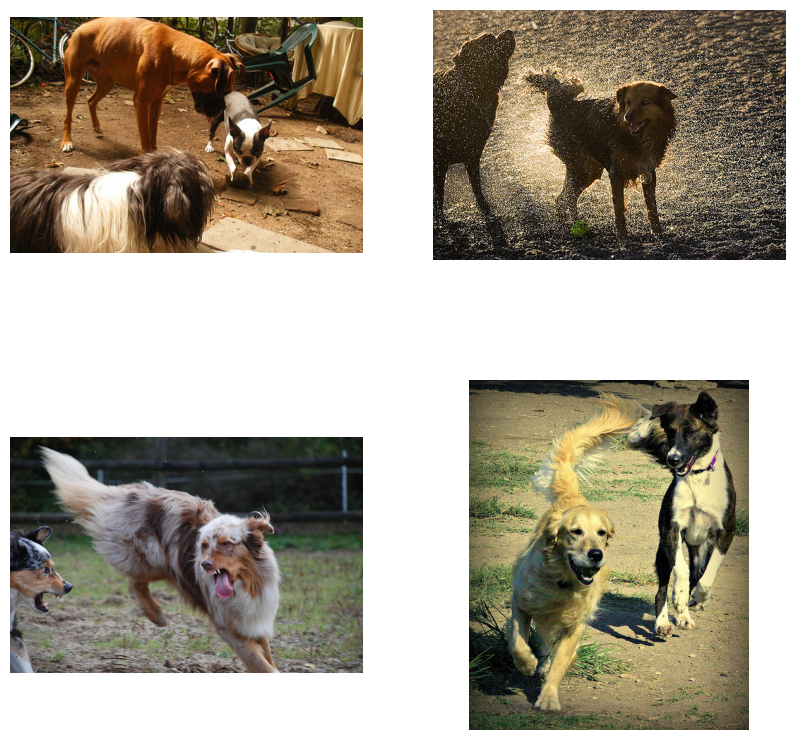

In [14]:
find_match(model, image_embeddings, "dogs", valid_df["image"].values)

## Опишите свои результаты.

Моделька в целом хорошо себя показала и сопоставляет картинку тексту достаточно неплохо. На большем датасете конечно качества можно было и побольше выбить, но что есть, то есть. 